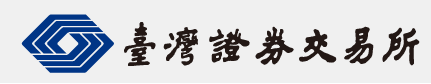

台灣證券交易所網站: https://www.twse.com.tw/zh/

程式參考網站:https://www.finlab.tw/Python-%E7%B0%A1%E5%96%AE158%E7%A8%AE%E6%8A%80%E8%A1%93%E6%8C%87%E6%A8%99%E8%A8%88%E7%AE%97/

讀取 30天 資料

## 只有上市 部分

In [ ]:
import requests
import pandas as pd
import os

dates = [20200801, 20200701, 20200601, 20200501, 20200401, 20200301, 20200201, 20200101, 20191201, 20191101, 20191001, 20190901]
stockNo = 2330
url_template = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=html&date={}&stockNo={}"

data_path = "./get_data/"
if not os.path.isdir(data_path):
    os.mkdir(data_path)
        
for date in dates :
    url = url_template.format(date, stockNo)
    file_name = "{}_{}.csv".format(stockNo, date)
    
    data = pd.read_html(requests.get(url).text)[0]
    data.columns = data.columns.droplevel(0)
    data.to_csv(data_path + file_name, index=False)

In [ ]:
import requests
import pandas as pd
import os

dates = [20200801]
stockNo = 2330
url_template = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=html&date={}&stockNo={}"

data_path = "./get_data/"
if not os.path.isdir(data_path):
    os.mkdir(data_path)
        
for date in dates :
    url = url_template.format(date, stockNo)
    file_name = "{}_{}.csv".format(stockNo, date)
    
    data = pd.read_html(requests.get(url).text)[0]
    data.columns = data.columns.droplevel(0)
    data.to_csv(data_path + file_name, index=False)

In [ ]:
import requests
from bs4 import BeautifulSoup
###############################################################################
#                         股票行動機器人  【Post爬蟲】                        #
###############################################################################

# 要抓取的網址
url = 'https://goodinfo.tw/StockInfo/StockDividendPolicy.asp?STOCK_ID=2409'
# 附帶的資料必須要有
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36' }

#請求網站
list_req = requests.post(url, headers = headers)
#將整個網站的程式碼爬下來
soup = BeautifulSoup(list_req.content, "html.parser")

In [ ]:
soup

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 16 13:09:54 2019
@author: cheating
"""

import datetime
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import time
from io import StringIO
import random
###############################################################################
#                           股票機器人   選股範例                             #
###############################################################################
'''
選股條件：
（１）評估價值是否被低估？（股票價格不會太貴）
１．本益比　＜１５倍
２．現金殖利率 　＞５％
（２）確定本業利益是成長的，且為本業賺的（不是靠業外收益賺的，獲利不持久）
１．營收累計年增率　＞　０％
２．毛利率　＞　０％
３．營業益益率　＞　０％
４．稅前淨利率　＞０％
５．稅後淨利率　＞０％
６．本業收益（營業利益率／稅前淨利率）　＞６０％
（３）確定配息不是虛假的．（營運現金流有賺錢，才可以配股息）
１．近一年（２０１７）營運現金流　＞０
２．近一季（２０１８Ｑ３）營運現金流　＞０
以上確定選出來的股票是低本益比＋高殖利率，未避免條件過於嚴格，所以先由寬至嚴，若標準太低，導致選出來的股票較多，可以把條件設嚴格．
二．技術面（這是確定底部打好，且已經向上，不摸底）
１．股價　＞　均線ＭＡ１０
２．股價　＞　均線ＭＡ２０
３．均線ＭＡ１０　與　均線ＭＡ２０　呈現黃金交叉
三．籌碼面
１．董監持股　＞　１０％以上
２．法人持續買超天數　＞　２天
董監持股高，對於公司有信心
三大法人持續買超二天以上，至少短時間看好
'''

#----------------- （１）評估價值是否被低估？（股票價格不會太貴） -------------
########## 去公開資訊觀測站，把本益比、股價淨值比爬下來 ##########
url = 'http://www.twse.com.tw/exchangeReport/BWIBBU_d?response=json&date=&selectType=&_=' + str(time.time())
list_req = requests.get(url)
soup = BeautifulSoup(list_req.content, "html.parser")
getjson=json.loads(soup.text)

# 因為是表格式，用dataframe處理會比較方便
stockdf = pd.DataFrame(getjson['data'],columns=["證券代號","證券名稱","殖利率(%)","股利年度","本益比","股價淨值比","財報年/季"])
PBR = pd.to_numeric(stockdf['股價淨值比'], errors='coerce') < 0.5 # 找到股價淨值比小於0.7的股票
EPS = pd.to_numeric(stockdf['本益比'], errors='coerce') < 15 # 找到本益比小於15的股票
candidate= stockdf[(PBR & EPS)] # 綜合以上兩者，選出兩者皆符合的股票

In [ ]:




#------------------------------ 基本面財報檢查 --------------------------------

### 現在時間處裡 ###
now = datetime.datetime.now() #現在的時間
year = now.strftime("%Y") #抓今年
lastmonth = now - datetime.timedelta(days=31) #一個月前的時間

candidate2=[]
for stock in candidate['證券代號'].values:
    for season in range(4,0,-1):
        ### 先與網站請求抓到每天的報價資料 ###
        url = 'http://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=' + stock + '&SYEAR=' + year + '&SSEASON=' + str(season) + '&REPORT_ID=C'
        
        #要睡覺一下，不然會被ben掉
        time.sleep(random.randint(0,10))
        getdata=pd.read_html(url,encoding='utf16',header=0)
        
        if len(getdata) > 1: # 檢查'查無資料'
            break
            
    ### 檢查'查無資料'
    if len(getdata) == 1:
        url = 'http://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=' + stock + '&SYEAR=' + str(int(year)-1) + '&SSEASON=4&REPORT_ID=C'
        #要睡覺一下，不然會被ben掉
        time.sleep(random.randint(0,10))
        getdata=pd.read_html(url,encoding='utf16',header=0)
    
    ### 檢查'查無資料'
    if len(getdata) == 1: 
        url = 'http://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=' + stock + '&SYEAR=' + str(int(year)-1) + '&SSEASON=3&REPORT_ID=C' 
        #要睡覺一下，不然會被ben掉
        time.sleep(random.randint(0,10))
        getdata=pd.read_html(url,encoding='utf16',header=0)
    
    del getdata[0] #殺掉第一個，因為第一個沒有意義
    
    #------------------------------先顯示目前價格----------------------------------
    # 要抓取的網址
    url = 'https://tw.stock.yahoo.com/q/q?s=' + stock 
    #請求網站
    list_req = requests.get(url)
    #將整個網站的程式碼爬下來
    soup = BeautifulSoup(list_req.content, "html.parser")
    #找到b這個標籤
    get_stock_price= soup.findAll('b')[1].text #裡面所有文字內容

    if len(getdata) > 0 :
        #營收要比去年高
        if getdata[1][getdata[1]['會計項目']=='營業收入合計'].values[0][3] > getdata[1][getdata[1]['會計項目']=='營業收入合計'].values[0][4]:
            #毛利跟營收要是正的
            if getdata[1][getdata[1]['會計項目']=='營業收入合計'].values[0][3] >0 and getdata[1][getdata[1]['會計項目']=='營業毛利（毛損）淨額'].values[0][3] >0:
                #營業利益是正的
                if getdata[1][getdata[1]['會計項目']=='營業利益（損失）'].values[0][3] >0:
                    #稅前稅後淨利是正的
                    if getdata[1][getdata[1]['會計項目']=='繼續營業單位稅前淨利（淨損）'].values[0][3] >0 and getdata[1][getdata[1]['會計項目']=='繼續營業單位本期淨利（淨損）'].values[0][3] >0:
                        #本業收益（營業利益率／稅前淨利率）　＞６０％
                        if (getdata[1][getdata[1]['會計項目']=='營業利益（損失）'].values[0][3]/getdata[1][getdata[1]['會計項目']=='營業收入合計'].values[0][3])/(getdata[1][getdata[1]['會計項目']=='繼續營業單位稅前淨利（淨損）'].values[0][3]/getdata[1][getdata[1]['會計項目']=='營業收入合計'].values[0][3]) > 0.6:
                            #營運現金是正的>0
                            if getdata[2][getdata[2]['會計項目']=='本期現金及約當現金增加（減少）數'].values[0][1] > 0 and getdata[2][getdata[2]['會計項目']=='本期現金及約當現金增加（減少）數'].values[0][2] > 0:
                                
                                #檢查價格超過MA10、MA20
                                avgprice=[]
                                url = 'http://www.twse.com.tw/exchangeReport/STOCK_DAY_AVG?response=json&date=' + now.strftime("%Y%m%d") + '&stockNo=' + stock
                                
                                #要睡覺一下，不然會被ben掉
                                time.sleep(random.randint(0,10))
                               
                                list_req = requests.get(url) #請求網站
                                soup = BeautifulSoup(list_req.content, "html.parser") #將整個網站的程式碼爬下來
                                jsonsoup=json.loads(str(soup))
                                for i in range(len(jsonsoup['data'])-1):
                                    avgprice.append(float(jsonsoup['data'][i][1]))
                                
                                #如果不夠20日，就爬上個月的價格    
                                if len(avgprice) < 19:
                                    url = 'http://www.twse.com.tw/exchangeReport/STOCK_DAY_AVG?response=json&date=' + lastmonth.strftime("%Y%m%d") + '&stockNo=' + stock
                                    
                                    #要睡覺一下，不然會被ben掉
                                    time.sleep(random.randint(0,10))
                                    
                                    list_req = requests.get(url) #請求網站
                                    soup = BeautifulSoup(list_req.content, "html.parser") #將整個網站的程式碼爬下來
                                    jsonsoup=json.loads(str(soup))
                                    for i in range(len(jsonsoup['data'])-1,1,-1):
                                        avgprice.append(float(jsonsoup['data'][i][1])) 
                                #計算出平均並且進行判斷
                                avg20=sum(avgprice[:20])/20
                                if avg20 < float(get_stock_price):
                                    avg10=sum(avgprice[:10])/10
                                    if avg10 < float(get_stock_price):
                                        #黃金交叉
                                        if avg20 < avg10:
                                            #檢查董監事持股比例
                                            data = {
                                            'step': '1',
                                            'firstin': '1',
                                            'off': '1',
                                            'queryName': 'co_id',
                                            'inpuType': 'co_id',
                                            'TYPEK': 'all',
                                            'isnew': 'true',
                                            'co_id': stock
                                                    }
                                    
                                            headers = {
                                                    'Host': 'mops.twse.com.tw',
                                                    'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'         
                                                    }
                                            
                                            url = 'http://mops.twse.com.tw/mops/web/stapap1'
                                            list_req = requests.post(url, data=data ,headers=headers)
                                            soup = BeautifulSoup(list_req.content, "html.parser")
                                            stockbroad=soup.find_all('td',{'style':'text-align:right !important;'})
                                            if int(stockbroad[-2:-1][0].text.replace(' ','').replace(',',''))/getdata[3][getdata[3]['Unnamed: 0']=='期末餘額'].values[0][2] >0.1:
                                            
                                                #檢查三大法人買賣狀況
                                                countstock=0
                                                sumstock=0
                                                for i in range(5,0,-1):
                                                    date = datetime.datetime.strftime(datetime.datetime.now() - datetime.timedelta(days=i),'%Y%m%d') 
                                                    r = requests.get('http://www.tse.com.tw/fund/T86?response=csv&date='+date+'&selectType=ALLBUT0999') 
                                                    if r.text != '\r\n': #有可能會沒有爬到東西，有可能是六日
                                                        countstock += 1
                                                        get = pd.read_csv(StringIO(r.text), header=1).dropna(how='all', axis=1).dropna(how='any') 
                                                        get=get[get['證券代號']==stock] # 找到我們要搜尋的股票
                                                        if len(get) >0:
                                                            get['三大法人買賣超股數'] = get['三大法人買賣超股數'].str.replace(',','').astype(float) 
                                                            if get['三大法人買賣超股數'].values[0] >0:
                                                                sumstock += 1
                                                
                                                if countstock == sumstock:
                                                    candidate2.append(stock)
    else:
        print(stock+'爬蟲失敗')
    #要睡覺一下，不然會被ben掉
    time.sleep(random.randint(5,30))

print(candidate2)